System Identification with LSTM
=================================

In [78]:
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.integrate import odeint

import random
from sklearn.model_selection import train_test_split

The next cell defines the `pend` function that contains the system of nonlinear differential equations representing the pendulum dynamics.

In [87]:
def fluid_flow(x, t, u, mu, omega, A, l):
    x1, x2, x3 = x 
    dxdt = [mu*x1 - omega*x1 + A*x1*x3 + u,
           omega*x1 - omega*x2 + A*x2*x3,
           -l*(x3 - x1**2 - x2**2)]
    return dxdt

In the cell below, the parameters of the pendulum dynamics, the initial condition vector and the time vector are defined. 

In [89]:
def generate_data_IO(t, n_instances, n_states, b, c):
    '''
    
    INPUTS:
    - 
    - 
    - kwargs: parameters of the system
    
    OUTPUTS:
    -
    -
    
    '''

    # Creating containers for the inputs and the outputs (i.e., random inputs and states) given a number of instances
    Y = np.zeros(shape = (n_instances, t.shape[0], n_states))

    # Container for inputs to the NN
    X = np.zeros(shape = (n_instances, t.shape[0], n_states))

    for n_inst in range(n_instances):

        u = np.random.rand(t.shape[0], )

        x0 = np.random.rand(n_states, )

        X[n_inst, 0, :] = x0
        Y[0, 0, :] = x0

        for k in range(len(t) - 1):

            # Integration time
            t_int = np.linspace(t[k], t[k+1], 200)

            # Integration
            x_int = odeint(fluid_flow, x0, t_int, args = (u[k], mu, omega, A, l))

            # Extracting the outputs
            for state in range(x_int.shape[-1]):
                Y[n_inst, k+1, state] = x_int[-1, state]

            # Updating initial condition for next integration
            x0 = x_int[-1, :]

        # Storing input in container for NN input
        X[n_inst, 1:, 0] = u[:k+1]
    
    return X, Y

t = np.linspace(0, 20, 500)

X, Y = generate_data_IO(t = t, n_instances = 1000, n_states = 3, b = 0.25, c = 5.00)
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

np.savez("X_all_fluid.npz", X)
np.savez("Y_all_fluid.npz", Y)

X: (1000, 500, 3)
Y: (1000, 500, 3)


In [91]:
n_instances = X.shape[0]
n_validation = int(0.1*X.shape[0])
ind_validation = random.sample(range(0, n_instances), n_validation)

X_valid = X[ind_validation, :, :]
Y_valid = Y[ind_validation, :, :]

X_all = np.delete(X, ind_validation, axis = 0)
Y_all = np.delete(Y, ind_validation, axis = 0)

X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 42)

print(f"X_train: {X_train.shape} - Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape} - Y_test: {Y_test.shape}")
print(f"X_valid: {X_valid.shape} - Y_valid: {Y_valid.shape}")

X_train: (720, 500, 3) - Y_train: (720, 500, 3)
X_test: (180, 500, 3) - Y_test: (180, 500, 3)
X_valid: (100, 500, 3) - Y_valid: (100, 500, 3)


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint

n_states = 3

model=Sequential()
model.add(LSTM(32,
               input_shape = (X_train.shape[1], X_train.shape[2]),
               return_sequences = True))
model.add(TimeDistributed(Dense(n_states)))
# does not make sense to use metrics=['acc'], see https://stackoverflow.com/questions/41819457/zero-accuracy-training-a-neural-network-in-keras
model.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 500, 32)           4608      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 500, 3)            99        
Total params: 4,707
Trainable params: 4,707
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_dir = os.path.abspath('sysid_test_lstm')

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

filepath = os.path.join(model_dir, 'LSTM_Model_SysID.hdf5') 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only = True, mode = 'min', patience = 10)
callbacks = [checkpoint]

hist = model.fit(X_train, Y_train, 
                 epochs = 20, batch_size = 100, 
                 callbacks = callbacks, 
                 validation_data = (X_valid, Y_valid),
                 verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 720 samples, validate on 100 samples
Epoch 1/20
720/720 [==============================] - 3s 5ms/sample - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.0202 - val_mean_squared_error: 0.0202
Epoch 2/20
720/720 [==============================] - 2s 3ms/sample - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 3/20
720/720 [==============================] - 2s 3ms/sample - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/20
720/720 [==============================] - 2s 3ms/sample - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 5/20
720/720 [==============================] - 2s 3ms/sample - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 6/20
720/720 [====================

In [95]:
# load the model with the smallest validation loss
model.load_weights(filepath)

# use the test data to predict the model response
Y_predict = model.predict(X_test)

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss)+1)

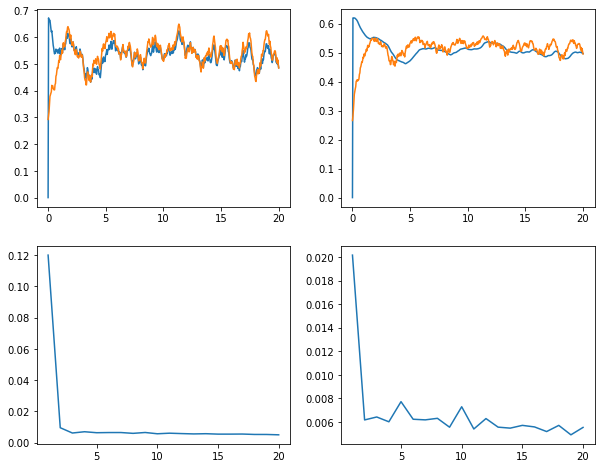

In [100]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))

axes[0][0].plot(t, Y_test[2, :, 0], label = "Ground Truth")
axes[0][0].plot(t, Y_predict[2,:,0], label = "Prediction")

# State 2
axes[0][1].plot(t, Y_test[2, :, 1], label = "Ground Truth")
axes[0][1].plot(t, Y_predict[2,:, 1], label = "Prediction")

# Loss function
axes[1][0].plot(epochs, loss, label = "Loss")
axes[1][1].plot(epochs, val_loss, label = "Validation Loss")